In [1]:
from datasets import tdsc
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision

In [3]:
dataset = tdsc.TDSC(path_to_dataset="data/tdsc", transformers=[ResizerTransformer(target_size=(256,256))])

In [8]:
x, m, l = dataset[1]
print (x.shape)

(256, 256, 15)


In [9]:
print (np.max(x))
print (np.max(m))

254
1


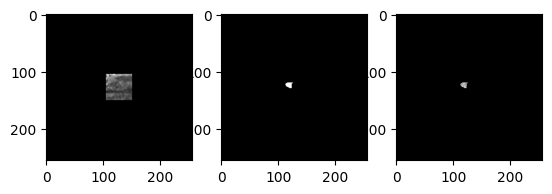

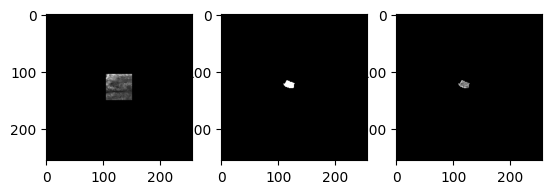

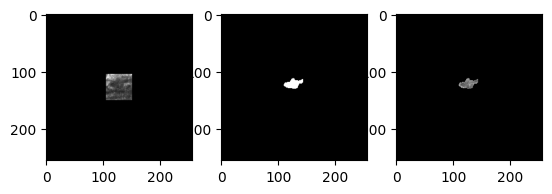

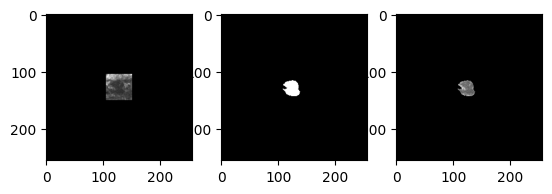

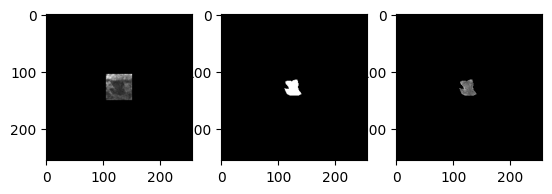

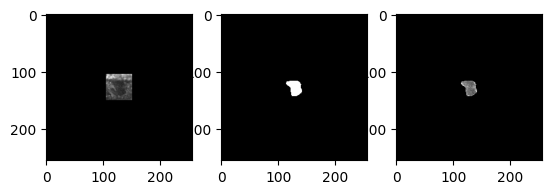

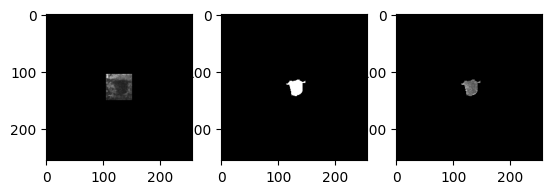

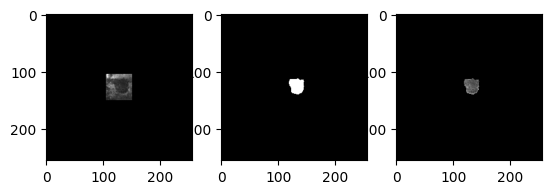

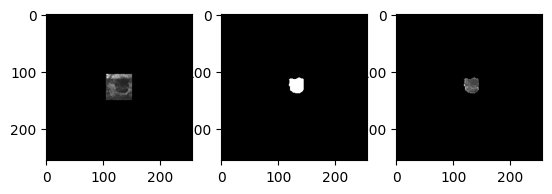

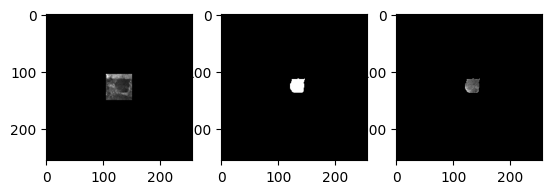

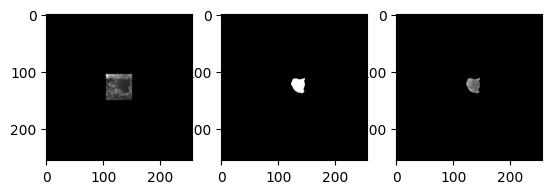

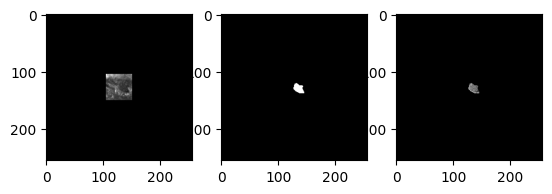

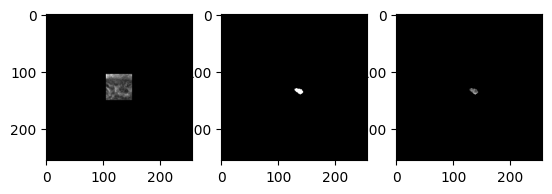

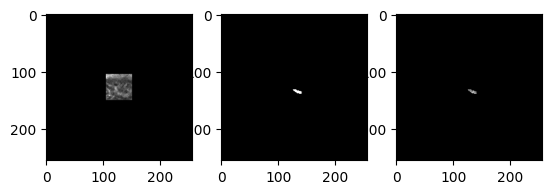

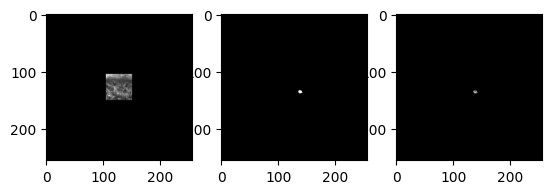

In [10]:
for i in range(x.shape[2]):
    plt.subplot(2,3,1)
    plt.imshow(x[:,:,i], cmap="gray")
    plt.subplot(2,3,2)
    plt.imshow(m[:,:,i]*255, cmap="gray")
    plt.subplot(2,3,3)
    plt.imshow(m[:,:,i]*x[:,:,i], cmap="gray")
    plt.show()

In [20]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        # Contracting Path
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Expansive Path
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, out_channels, kernel_size=2, stride=2)
        )

    def forward(self, x):
        # Contracting Path
        conv1 = self.encoder(x)
        conv2 = self.middle(conv1)
        
        # Expansive Path
        out = self.decoder(conv2)
        
        return out

# Transformers for Normalization, Data augmentation and Resizeing

In [3]:
class Normalizer:
    def __call__(self, sample):
        x, m = sample
        return x/255, m/np.max(m)

class ToTensorTransformer:
    def __call__(self, sample):
        x, m = sample
        return torch.from_numpy(x), torch.from_numpy(m)
    
class ResizerTransformer:
    
    def __init__ (self, target_size):
        self.target_size = target_size
    
    def __call__(self, sample):
        # Get the original image dimensions
        x, m = sample
        
        original_height, original_width, _ = x.shape
        
        # Set the target size
        target_size = (490, 490)

        # Calculate the padding needed
        padding_height = max(0, target_size[0] - original_height)
        padding_width = max(0, target_size[1] - original_width)

        # Calculate the padding amounts for top, bottom, left, and right
        top_padding = padding_height // 2
        bottom_padding = padding_height - top_padding
        left_padding = padding_width // 2
        right_padding = padding_width - left_padding

        # Create a border around the image with zero-padding
        image_with_padding = cv2.copyMakeBorder(
            x,
            top_padding,
            bottom_padding,
            left_padding,
            right_padding,
            cv2.BORDER_CONSTANT,
            value=(0, 0, 0)  # Set the padding color to black
        )
        
        mask_with_padding = cv2.copyMakeBorder(
            m,
            top_padding,
            bottom_padding,
            left_padding,
            right_padding,
            cv2.BORDER_CONSTANT,
            value=(0, 0, 0)  # Set the padding color to black
        )

        # Resize the image to the target size (490x490)
        resized_image = cv2.resize(image_with_padding, target_size)
        resized_mask = cv2.resize(mask_with_padding, target_size)
        
        
        resized_image = cv2.resize(image_with_padding, self.target_size)
        resized_mask = cv2.resize(mask_with_padding, self.target_size)
        
        return resized_image, resized_mask

In [21]:
dataset = tdsc.TDSC(path_to_dataset="data/tdsc", transformers=[Normalizer(), ResizerTransformer(target_size=(256,256)), ToTensorTransformer()])
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1, shuffle=True, num_workers=2)

In [22]:
# Create the U-Net model
model = UNet(in_channels=1, out_channels=1)  # Input and output channels are both 1 for grayscale images

# Define your U-Net model and other hyperparameters
model = UNet(in_channels=1, out_channels=1)  # Adjust channels based on your data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss for binary segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

In [26]:
for epoch in range(100):
    model.train()
    running_loss = 0.0
    for x, m, y in dataloader:
        for i in range(x.shape[3]):
            sli =  x[:,:,:,i]
            mask = m[:,:,:,i]            
            sli, mask = sli.to(device), mask.to(device)    
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(sli)
            # Calculate the loss
            loss = criterion(outputs, mask)
            # Backpropagation and optimization
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")
    
print("Finished Training")

Epoch 1/10, Loss: 1.557054242012091
Epoch 2/10, Loss: 1.5132905519986526
Epoch 3/10, Loss: 1.5082823343132623
Epoch 4/10, Loss: 1.5185113733645994
Epoch 5/10, Loss: 1.5298680511547718
Epoch 6/10, Loss: 1.5165674119314645
Epoch 7/10, Loss: 1.5012635964923537
Epoch 8/10, Loss: 1.4973318191070575
Epoch 9/10, Loss: 1.5310986344557023
Epoch 10/10, Loss: 1.4752591552835657
Epoch 11/10, Loss: 1.4797248033393406
Epoch 12/10, Loss: 1.4777789990918244
Epoch 13/10, Loss: 1.436178755692672
Epoch 14/10, Loss: 1.4592628350970336
Epoch 15/10, Loss: 1.4738509019766934
Epoch 16/10, Loss: 1.4357709490938577
Epoch 17/10, Loss: 1.4133371888799593
Epoch 18/10, Loss: 1.4082274292234798
Epoch 19/10, Loss: 1.434008001917973
Epoch 20/10, Loss: 1.4117170836799777
Epoch 21/10, Loss: 1.4016774885886116
Epoch 22/10, Loss: 1.4031991220102646
Epoch 23/10, Loss: 1.4165849074919243
Epoch 24/10, Loss: 1.4081194229563698
Epoch 25/10, Loss: 1.4127651373681147
Epoch 26/10, Loss: 1.410266297160415
Epoch 27/10, Loss: 1.3689

In [12]:
import os
import numpy as np

In [13]:
data = os.listdir("data/carvana/train/data")
print(data)

['0495dcf27283_13.jpg', '4dc8a7fe7c02_11.jpg', '1adaeb44f109_15.jpg', 'bec93f7ddb19_14.jpg', 'c24b8293eceb_14.jpg', '768f299c36e1_01.jpg', 'fdc2c87853ce_16.jpg', '98ee0624de87_03.jpg', 'e5fc2c1c4a8b_12.jpg', 'acb0fd30b83d_05.jpg', '6a951d3a3131_10.jpg', 'f591b4f2e006_11.jpg', 'dd47eb7ac4ee_09.jpg', 'eefc0d8c94f0_04.jpg', 'ebfdf6ec7ede_13.jpg', '2cb91c2543fa_10.jpg', '424658d9f222_14.jpg', '8b88fb784951_05.jpg', '6c0cd487abcd_06.jpg', '6a951d3a3131_03.jpg', '6ae670e86620_16.jpg', '169f5f6d8c9d_13.jpg', '11f3dc041cfb_09.jpg', '4e308ad8a254_08.jpg', '0cdf5b5d0ce1_10.jpg', '6131a03dd028_02.jpg', '34b0c08544a5_04.jpg', 'a4551c5409e3_16.jpg', '42d81612e2ce_10.jpg', '6bff9e10288e_07.jpg', '93881caf9f70_04.jpg', '3c6acfceb552_03.jpg', '2990f858e939_01.jpg', '6d21aad248e4_02.jpg', '2faf504842df_05.jpg', '189a2a32a615_02.jpg', '32ff007d9505_14.jpg', '6752de44b721_11.jpg', '154ee2b6d27a_13.jpg', '3bca821c8c41_01.jpg', 'c52b272a5329_06.jpg', 'df642435a951_14.jpg', 'd8216041ffa9_02.jpg', '9cc257b44

In [14]:
vali_idxs = np.random.randint(0, len(data), int(len(data)*0.2))
print(vali_idxs)

[ 536 2512  524 ... 4435 2126 3010]


In [15]:
s = data[0]
ss = s.replace('.jpg', '_mask.gif')
print(ss)

0495dcf27283_13_mask.gif


In [16]:
import shutil

def move_file(src, dest):
    shutil.move(src, dest)

In [18]:
for idx in vali_idxs:
    try:
        d = data[idx]
        m = d.replace('.jpg', '_mask.gif')
        move_file(f"./data/carvana/train/data/{d}", f"./data/carvana/validation/data/")
        move_file(f"./data/carvana/train/mask/{m}", f"./data/carvana/validation/mask/")
    except Exception as ex:
        print (ex)
        print(d)
        print(m)

Destination path './data/carvana/validation/data/0de66245f268_04.jpg' already exists
0de66245f268_04.jpg
0de66245f268_04_mask.gif
Destination path './data/carvana/validation/data/3cb21125f126_15.jpg' already exists
3cb21125f126_15.jpg
3cb21125f126_15_mask.gif
Destination path './data/carvana/validation/data/70b6a79565fe_14.jpg' already exists
70b6a79565fe_14.jpg
70b6a79565fe_14_mask.gif
Destination path './data/carvana/validation/data/a070dbb32d2b_01.jpg' already exists
a070dbb32d2b_01.jpg
a070dbb32d2b_01_mask.gif
Destination path './data/carvana/validation/data/d0392fd5feb6_13.jpg' already exists
d0392fd5feb6_13.jpg
d0392fd5feb6_13_mask.gif
Destination path './data/carvana/validation/data/f3eee6348205_16.jpg' already exists
f3eee6348205_16.jpg
f3eee6348205_16_mask.gif
Destination path './data/carvana/validation/data/48b3f0c936b5_04.jpg' already exists
48b3f0c936b5_04.jpg
48b3f0c936b5_04_mask.gif
Destination path './data/carvana/validation/data/69fba9e8f572_15.jpg' already exists
69fba

In [19]:
val_data = os.listdir("./data/carvana/validation/data/")
vali_mask = os.listdir("./data/carvana/validation/mask/")

In [20]:
print(len(val_data), len(vali_mask))

923 923


In [21]:
data = os.listdir("./data/carvana/train/data/")
mask = os.listdir("./data/carvana/train/mask/")
print(len(data), len(mask))

4165 4165
